In [32]:
import ase.io
import numpy as np
import copy
import matplotlib.pyplot as plt
import functools 
import torch

In [64]:
frames = ase.io.read('./gp_iter6_sparse9k.xml.xyz', ':')

# Preprocessing dataset

In [65]:
print(len(frames))

2475


## get energy (eV)

In [66]:
frames = [frame for frame in frames if ('dft_energy' in frame.info.keys()) or ('DFT_energy' in frame.info.keys())]
print(len(frames))

2475


## dress energies (atom 1 is isolated atom energy) and convert to eV/atom

In [67]:
dressed_energies_per_atom = []
# energy of one isolated Si atom
baseline_energy = frames[0].info['dft_energy'] 
for frame in frames:
    energy = frame.info['dft_energy'] if ('dft_energy' in frame.info.keys()) else frame.info['DFT_energy']
    frame.info['energy'] = energy
    energy -= baseline_energy*len(frame)
    frame.info['dressed_energy'] = energy
    energy /= len(frame)
    frame.info['dressed_energy_per_atom'] = energy
    dressed_energies_per_atom.append( energy )
frames = frames[1:] # the first structure causes high error
print(len(frames))

2474


In [68]:
dressed_energies_per_atom = np.array(dressed_energies_per_atom)

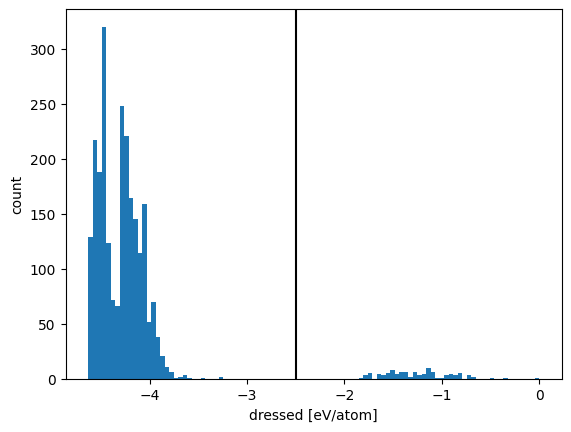

In [69]:
plt.hist(dressed_energies_per_atom, bins=100)
plt.axvline(-2.5, color='black')
plt.xlabel('dressed [eV/atom]')
plt.ylabel('count')
plt.show()
plt.close()

## Remove everything above -2.5, causes the error to be to dependent on the train-test split

In [70]:
frames = [frame for frame in frames if frame.info['dressed_energy_per_atom'] < -2.5]
dressed_energies_per_atom = np.array([frame.info['dressed_energy_per_atom'] for frame in frames])

In [71]:
print(len(frames))

2374


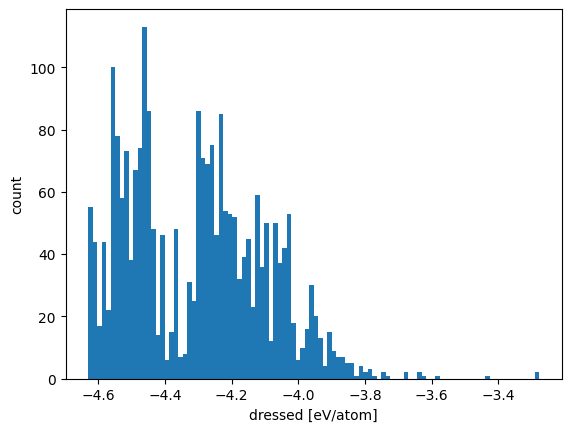

In [73]:
plt.hist(dressed_energies_per_atom, bins=100)
plt.xlabel('dressed [eV/atom]')
plt.ylabel('count')
plt.show()
plt.close()

## Center 

In [74]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_std=False).fit(dressed_energies_per_atom.reshape(-1,1))
scaled_dressed_energies_per_atom = scaler.transform(dressed_energies_per_atom.reshape(-1,1)).reshape(-1)
for i, frame in enumerate(frames):
    frame.info['scaled_dressed_energies_per_atom'] = scaled_dressed_energies_per_atom[i]


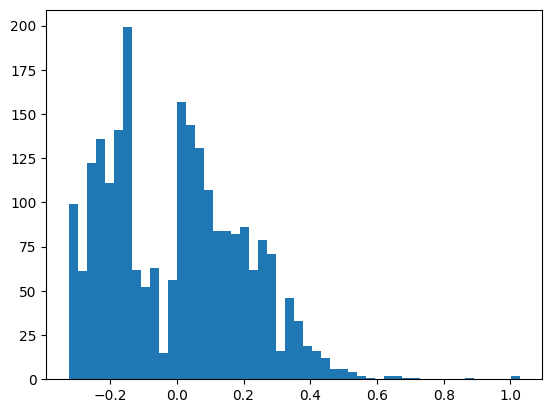

In [76]:
plt.hist(scaled_dressed_energies_per_atom, bins=50)
plt.show()
plt.close()

# utils

In [77]:
from collections import defaultdict

import numpy as np
import torch
from typing import Dict, List, Tuple, TypeVar, Callable, Optional
import ase

import abc
AtomicStructure = TypeVar('AtomicStructure')

def structure_to_torch(structure : AtomicStructure,
        device : Optional[torch.device] = None,
        dtype: Optional[torch.dtype] = None) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    :returns:
        Tuple of posititions, species, cell and periodic boundary conditions
    """
    if isinstance(structure, ase.Atoms):
        # dtype is automatically referred from the type in the structure object if None
        positions = torch.tensor(structure.positions, device=device, dtype=dtype)
        species = torch.tensor(structure.numbers, device=device)
        cell = torch.tensor(structure.cell.array, device=device, dtype=dtype)
        pbc = torch.tensor(structure.pbc, device=device)
        return positions, species, cell, pbc
    else:
        raise ValueError("Unknown atom type. We only support ase.Atoms at the moment.")

def build_neighborlist(positions: torch.Tensor, cell: torch.Tensor, pbc: torch.Tensor, cutoff : float) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:

    assert positions.device == cell.device
    assert positions.device == pbc.device
    device = positions.device

    # will be replaced with something with GPU support
    pairs_i, pairs_j, cell_shifts = ase.neighborlist.primitive_neighbor_list(
        quantities="ijS",
        positions=positions.detach().cpu().numpy(),
        cell=cell.detach().cpu().numpy(),
        pbc=pbc.detach().cpu().numpy(),
        cutoff=cutoff,
        self_interaction=False,
        use_scaled_positions=False,
    )
    pairs_i = torch.tensor(pairs_i, device=device)
    pairs_j = torch.tensor(pairs_j, device=device)
    cell_shifts = torch.tensor(cell_shifts, device=device)

    pairs = torch.vstack([pairs_i, pairs_j]).T
    centers = torch.arange(len(positions), device=device)
    return centers, pairs, cell_shifts


class TransformerBase(metaclass=abc.ABCMeta):
    """
    Abstract class for extracting information of an AtomicStructure objects and processing it
    """
    @abc.abstractmethod
    def __call__(self, structure: AtomicStructure) -> Dict[str, torch.Tensor]:
        pass

class TransformerProperty(TransformerBase):
    """
    Extracts property information out of an AtomicStructure using a function given as input
    """
    def __init__(self, property_name: List[str], get_property: List[Callable[[AtomicStructure], torch.Tensor]],
            device=None, dtype=None):
        if not(isinstance(get_property, list)):
            property_name = [property_name]
        if not(isinstance (get_property, list)):
            get_property = [get_property]
        self._get_property = get_property
        self._property_name = property_name
        self._device = device
        self._dtype = dtype


    def __call__(self, structure: AtomicStructure) -> Dict[str, torch.Tensor]:
        return {self._property_name[i]: self._get_property[i](structure).to(device=self._device, dtype=self._dtype)
                for i in range(len(self._property_name))}

class TransformerNeighborList(TransformerBase):
    """
    Produces a neighbour list and with direction vectors from an AtomicStructure
    """
    def __init__(self, cutoff: float, device=None, dtype=None):
        self._cutoff = cutoff
        self._device = device
        self._dtype = dtype

    def __call__(self, structure: AtomicStructure) -> Dict[str, torch.Tensor]:
        positions_i, species_i, cell_i, pbc_i = structure_to_torch(structure,
                dtype=self._dtype, device=self._device)
        centers_i, pairs_ij, cell_shifts_ij = build_neighborlist(positions_i, cell_i,
                pbc_i, self._cutoff)

        return {
            'positions': positions_i,
            'species': species_i,
            'cell': cell_i,
            'centers': centers_i,
            'pairs': pairs_ij,
            'cell_shifts': cell_shifts_ij
        }

# Temporary Dataset until we have an metatensor Dataset
class InMemoryDataset(torch.utils.data.Dataset):
    def __init__(self,
                 structures : List[AtomicStructure],
                 transformers : List[TransformerBase]):
        super().__init__()
        self.n_structures = len(structures)
        self._data = defaultdict(list)
        for structure in structures:
            for transformer in transformers:
                data_i = transformer(structure)
                for key in data_i.keys():
                    self._data[key].append(data_i[key])

    def __getitem__(self, idx):
        return {key: self._data[key][idx] for key in self._data.keys()}

    def __len__(self):
        return self.n_structures

def collate_nl(data_list, device=None, dtype=None):

    collated = {key: torch.concatenate([data[key].to(device=device) for data in data_list], dim=0)
                for key in filter(lambda x : x not in ["positions", "cell"], data_list[0].keys())}
    collated['positions'] = torch.concatenate([data["positions"] for data in data_list]).to(dtype=dtype, device=device)
    collated['cells'] = torch.stack([data["cell"] for data in data_list]).to(dtype=dtype, device=device)
    collated['structure_centers'] = torch.concatenate(
        [torch.tensor([structure_index] * len(data_list[structure_index]["centers"]), dtype=torch.long, device=collated["positions"].device) for structure_index in range(len(data_list))]
    ).to(device=device)
    collated['structure_pairs'] = torch.concatenate(
        [torch.tensor([structure_index] * len(data_list[structure_index]["pairs"]), dtype=torch.long, device=collated["positions"].device) for structure_index in range(len(data_list))]
    ).to(device=device)
    collated['structure_offsets'] = torch.tensor(
        np.cumsum([0] + [structure_data["positions"].shape[0] for structure_data in data_list[:-1]]),
        device=collated["positions"][0].device,
        dtype=torch.long
    ).to(device=device)
    return collated

def get_dressed_energy_per_atom(frame) -> torch.Tensor:
    return torch.tensor([frame.info['scaled_dressed_energies_per_atom']])

In [156]:
from torch import nn
import math

class CosineCutoff(nn.Module):
    r""" Behler-style cosine cutoff module.

    .. math::
       f(r) = \begin{cases}
        0.5 \times \left[1 + \cos\left(\frac{\pi r}{r_\text{cutoff}}\right)\right]
          & r < r_\text{cutoff} \\
        0 & r \geqslant r_\text{cutoff} \\
        \end{cases}

    """

    def __init__(self, cutoff: float):
        """
        Args:
            cutoff (float, optional): cutoff radius.
        """
        super(CosineCutoff, self).__init__()
        self.register_buffer("cutoff", torch.FloatTensor([cutoff]))

    def forward(self, input: torch.Tensor):
        return cosine_cutoff(input, self.cutoff)

def cosine_cutoff(input: torch.Tensor, cutoff: torch.Tensor):
    """ Behler-style cosine cutoff.

        .. math::
           f(r) = \begin{cases}
            0.5 \times \left[1 + \cos\left(\frac{\pi r}{r_\text{cutoff}}\right)\right]
              & r < r_\text{cutoff} \\
            0 & r \geqslant r_\text{cutoff} \\
            \end{cases}

        Args:
            cutoff (float, optional): cutoff radius.

        """

    # Compute values of cutoff function
    input_cut = 0.5 * (torch.cos(input * math.pi / cutoff) + 1.0)
    # Remove contributions beyond the cutoff radius
    input_cut *= (input < cutoff).float()
    return input_cut


class GaussianRBF(nn.Module):
    r"""Gaussian radial basis functions."""

    def __init__(
        self, n_rbf: int, cutoff: float, start: float = 0.0, sigma: float = None ,trainable: bool = False
    ):
        """
        Args:
            n_rbf: total number of Gaussian functions, :math:`N_g`.
            cutoff: center of last Gaussian function, :math:`\mu_{N_g}`
            start: center of first Gaussian function, :math:`\mu_0`.
            trainable: If True, widths and offset of Gaussian functions
                are adjusted during training process.
        """
        super(GaussianRBF, self).__init__()
        self.n_rbf = n_rbf

        # compute offset and width of Gaussian functions
        offset = torch.linspace(start, cutoff, n_rbf)
        if sigma is None:
            widths = torch.FloatTensor(
                torch.abs(offset[1] - offset[0]) * torch.ones_like(offset)
            )
        else:
            widths = sigma *  torch.ones_like(offset)
        if trainable:
            self.widths = nn.Parameter(widths)
            self.offsets = nn.Parameter(offset)
        else:
            self.register_buffer("widths", widths)
            self.register_buffer("offsets", offset)

    def forward(self, inputs: torch.Tensor):
        return gaussian_rbf(inputs, self.offsets, self.widths)

def gaussian_rbf(inputs: torch.Tensor, offsets: torch.Tensor, widths: torch.Tensor):
    coeff = -0.5 / torch.pow(widths, 2)
    diff = inputs[..., None] - offsets
    midcoeff = coeff * torch.pow(diff, 2)
    y = torch.exp(midcoeff)
    # approximation of exp, because of gradient bug
    #y = 1+midcoeff+(midcoeff**2)/2+(midcoeff**3)/6+(midcoeff**4)/24+(midcoeff**5)/120
    return y

class Embedding(nn.Module):

    def __init__(
        self, feature_size: int, cutoff: float, cutoff_fn: bool = True, sigma: float = None, trainable:bool = False
    ):
        super().__init__()
        self._feature_size = feature_size
        self._cutoff = cutoff
        self._expansion = GaussianRBF(n_rbf=feature_size, cutoff=cutoff, trainable=trainable, sigma=sigma)
        self._cutoff_module = CosineCutoff(cutoff)
        self._cutoff_fn = cutoff_fn

    def forward(self, r: torch.Tensor):
        x = self._expansion(r)
        if self._cutoff_fn:
            x *= self._cutoff_module(r).unsqueeze(-1)
        return x


In [79]:
x = np.linspace(0,CUTOFF,100)
plt.plot(x, 1+x+(x**2)/2+(x**3)/6+(x**4)/24+(x**5)/120)
plt.show()
plt.close()

NameError: name 'CUTOFF' is not defined

In [80]:

def get_cartesian_vectors(positions,
                          cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets):
    """
    Wraps direction vectors into TensorBlock object with metadata information
    """

    # calculate interatomic vectors
    pairs_offsets = structure_offsets[structure_pairs]
    shifted_pairs = pairs_offsets[:, None] + pairs
    shifted_pairs_i = shifted_pairs[:, 0]
    shifted_pairs_j = shifted_pairs[:, 1]
    direction_vectors = positions[shifted_pairs_j] - positions[shifted_pairs_i] + torch.einsum("ab, abc -> ac", cell_shifts.to(cells.dtype), cells[structure_pairs])

    # find associated metadata
    #pairs_i = pairs[:, 0]
    #pairs_j = pairs[:, 1]
    #labels = torch.stack([
    #    structure_pairs,
    #    pairs_i,
    #    pairs_j,
    #    species[shifted_pairs_i],
    #    species[shifted_pairs_j],
    #    cell_shifts[:, 0],
    #    cell_shifts[:, 1],
    #    cell_shifts[:, 2]
    #], dim=-1)
    return direction_vectors

# globals

In [81]:
CUTOFF = 6.
#torch.set_default_device("cuda:0")
DTYPE = torch.float32
DEVICE = "cuda"
collate_nl_and_move = functools.partial(collate_nl, dtype=DTYPE, device=DEVICE)

# some debug

In [82]:
dataset = InMemoryDataset(frames[:200],
                          [TransformerNeighborList(cutoff=CUTOFF),
                           TransformerProperty("scaled_dressed_energies_per_atom", get_dressed_energy_per_atom)])

In [83]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, collate_fn=collate_nl, shuffle=False)

In [84]:
next(iter(dataloader))

{'species': tensor([14, 14]),
 'centers': tensor([0, 0]),
 'pairs': tensor([[0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0]

# Model - Spliney

## center and neighbor are separate interaction blocks

In [153]:
from copy import deepcopy

class Spliney(torch.nn.Module):
    def __init__(self,
                cutoff: float,
                feature_size: int = 128,
                layers_per_interaction = 6,
                self_interaction: int = 5,
                neighbor_interaction: int = 0,
                sigma: float = None,
                dtype = None,
                device = None):
        super().__init__()
        self._feature_size = feature_size
        self._layers_per_interaction = layers_per_interaction
        self._self_interaction = self_interaction
        self._neighbor_interaction = neighbor_interaction

        self._embedding = Embedding(feature_size=feature_size, cutoff=cutoff, sigma=sigma)
        self._embedding.to(device=device, dtype=dtype)
        self._layer = torch.nn.Sequential(
                        torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device),
                        torch.nn.SiLU())
        # TODO rename to input_layers
        self._layers = torch.nn.Sequential(*[deepcopy(self._layer) for i in range(self._layers_per_interaction)])
        self._self_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._self_interaction)])
        self._neighbor_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._neighbor_interaction)])
        
        self._output_layer = torch.nn.Linear(self._feature_size, 1, dtype=dtype, device=device)
        self._self_interaction_linear_layers =  torch.nn.Sequential(*[deepcopy(self._output_layer) for i in range(self._self_interaction)])
        self._neighbor_interaction_linear_layers =  torch.nn.Sequential(*[deepcopy(self._output_layer) for i in range(self._neighbor_interaction)])

    def forward(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):

        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)

        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
        pairs_j = structure_offsets[structure_pairs] + pairs[:, 1]
        #assert torch.allclose(torch.unique(centers_i), centers_i)
        #assert torch.allclose(torch.arange(len(centers_i)), centers_i)
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        
        embedding = self._embedding(r)

        pair_x = self._layers(embedding)
        # this pair_E_x is splined
        pair_E = self._output_layer(pair_x)
        #torch.zeros(len(centers_i), embedding.shape[-1], dtype=embedding.dtype)

        for i in range(len(self._self_interaction_layers)):
            # central representation becomes weight
            center_w = torch.zeros(len(centers_i), pair_E.shape[-1], dtype=pair_E.dtype, device=pair_E.device)
            center_w.index_reduce_(0, pairs_i, pair_E, reduce="mean")
            # new representation is computed
            pair_x = self._self_interaction_layers[i](embedding)
            pair_E = self._self_interaction_linear_layers[i](pair_x)
            # multiply pair energies with weights
            #pair_E = torch.cat([pair_E[pairs_i==i] * center_w[i] for i in range(len(centers_i))]) same line as below
            pair_E = pair_E * center_w[pairs_i]
                    
        for i in range(len(self._neighbor_interaction_layers)):
            center_w = torch.zeros(len(centers_i), pair_E.shape[-1], dtype=pair_E.dtype, device=pair_E.device)
            center_w.index_reduce_(0, pairs_i, pair_E, reduce="mean")
            #center_w.index_add_(0, pairs_i, pair_E)
            
            # new representation is computed
            pair_x = self._neighbor_interaction_layers[i](embedding)
            pair_E = self._neighbor_interaction_linear_layers[i](pair_x)
            # multiply pair energies with weights
            pair_E = pair_E * center_w[pairs_j]
            
        
        center_E = torch.zeros(len(centers_i), pair_E.shape[-1], dtype=pair_E.dtype, device=pair_E.device)
        center_E.index_add_(0, pairs_i, pair_E)

        y = torch.zeros(len(structure_offsets), center_E.shape[-1], dtype=center_E.dtype, device=center_E.device)
        y.index_reduce_(0, structure_centers, center_E, reduce="mean")
        y = y.squeeze()
        return y

## center and neighbor are merged to one interaction block

In [666]:
from copy import deepcopy

class Spliney(torch.nn.Module):
    def __init__(self,
                cutoff: float,
                feature_size: int = 128,
                layers_per_interaction = 6,
                interaction: int = 0,
                dtype = None,
                device = None):
        super().__init__()
        self._feature_size = feature_size
        self._layers_per_interaction = layers_per_interaction
        self._interaction = interaction

        self._embedding = Embedding(feature_size=feature_size, cutoff=cutoff)
        self._embedding.to(device=device, dtype=dtype)
        self._layer = torch.nn.Sequential(
                        torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device),
                        torch.nn.SiLU())
        # TODO rename to input_layers
        self._layers = torch.nn.Sequential(*[deepcopy(self._layer) for i in range(self._layers_per_interaction)])
        self._layers2 = torch.nn.Sequential(*[deepcopy(self._layer) for i in range(self._layers_per_interaction)])

        self._self_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._interaction)])
        self._neighbor_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._interaction)])
        
        self._output_layer = torch.nn.Linear(self._feature_size, 1, dtype=dtype, device=device)
        self._self_interaction_linear_layers =  torch.nn.Sequential(*[deepcopy(self._output_layer) for i in range(self._interaction)])
        self._neighbor_interaction_linear_layers =  torch.nn.Sequential(*[deepcopy(self._output_layer) for i in range(self._interaction)])

    def forward(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):

        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)

        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
        pairs_j = structure_offsets[structure_pairs] + pairs[:, 1]
        #assert torch.allclose(torch.unique(centers_i), centers_i)
        #assert torch.allclose(torch.arange(len(centers_i)), centers_i)
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        
        embedding = self._embedding(r)

        pair_x = self._layers(embedding)
        # this pair_E_x is splined
        pair_E = self._output_layer(pair_x)
        #torch.zeros(len(centers_i), embedding.shape[-1], dtype=embedding.dtype)

        for i in range(len(self._self_interaction_layers)):
            # central representation becomes weight
            center_w = torch.zeros(len(centers_i), pair_E.shape[-1], dtype=pair_E.dtype, device=pair_E.device)
            center_w.index_reduce_(0, pairs_i, pair_E, reduce="mean")
            #center_w.index_add_(0, pairs_i, pair_E)

            # new representation is computed
            pair_x = self._self_interaction_layers[i](embedding)
            pair_E = self._self_interaction_linear_layers[i](pair_x)
            # multiply pair energies with weights
            #pair_E = torch.cat([pair_E[pairs_i==i] * center_w[i] for i in range(len(centers_i))]) same line as below
            pair_E = pair_E * center_w[pairs_i]
                    
            center_w = torch.zeros(len(centers_i), pair_E.shape[-1], dtype=pair_E.dtype, device=pair_E.device)
            center_w.index_reduce_(0, pairs_i, pair_E, reduce="mean")
            #center_w.index_add_(0, pairs_i, pair_E)
            
            # new representation is computed
            pair_x = self._neighbor_interaction_layers[i](embedding)
            pair_E = self._neighbor_interaction_linear_layers[i](pair_x)
            # multiply pair energies with weights
            pair_E = pair_E * center_w[pairs_j]

        center_E = torch.zeros(len(centers_i), pair_E.shape[-1], dtype=pair_E.dtype, device=pair_E.device)
        center_E.index_add_(0, pairs_i, pair_E)

        y = torch.zeros(len(structure_offsets), center_E.shape[-1], dtype=center_E.dtype, device=center_E.device)
        y.index_reduce_(0, structure_centers, center_E, reduce="mean")
        y = y.squeeze()
        return y

## center and neighbor are ged to one interaction block - center and neighbor use same repr

In [659]:
from copy import deepcopy

class Spliney(torch.nn.Module):
    def __init__(self,
                cutoff: float,
                feature_size: int = 128,
                layers_per_interaction = 6,
                interaction: int = 0,
                dtype = None,
                device = None):
        super().__init__()
        self._feature_size = feature_size
        self._layers_per_interaction = layers_per_interaction
        self._interaction = interaction

        self._embedding = Embedding(feature_size=feature_size, cutoff=cutoff)
        self._embedding.to(device=device, dtype=dtype)
        self._layer = torch.nn.Sequential(
                        torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device),
                        torch.nn.SiLU())
        # TODO rename to input_layers
        self._layers = torch.nn.Sequential(*[deepcopy(self._layer) for i in range(self._layers_per_interaction)])
        self._self_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._interaction)])
        self._neighbor_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._interaction)])
        
        self._output_layer = torch.nn.Linear(self._feature_size, 1, dtype=dtype, device=device)
        self._self_interaction_linear_layers =  torch.nn.Sequential(*[deepcopy(self._output_layer) for i in range(self._interaction)])
        self._neighbor_interaction_linear_layers =  torch.nn.Sequential(*[deepcopy(self._output_layer) for i in range(self._interaction)])

    def forward(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):

        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)

        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
        pairs_j = structure_offsets[structure_pairs] + pairs[:, 1]
        #assert torch.allclose(torch.unique(centers_i), centers_i)
        #assert torch.allclose(torch.arange(len(centers_i)), centers_i)
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        
        embedding = self._embedding(r)

        pair_x = self._layers(embedding)
        # this pair_E_x is splined
        pair_E = self._output_layer(pair_x)
        #torch.zeros(len(centers_i), embedding.shape[-1], dtype=embedding.dtype)

        for i in range(len(self._self_interaction_layers)):
            # central representation becomes weight
            center_w = torch.zeros(len(centers_i), pair_E.shape[-1], dtype=pair_E.dtype, device=pair_E.device)
            center_w.index_reduce_(0, pairs_i, pair_E, reduce="mean")
            #center_w.index_add_(0, pairs_i, pair_E)

            # new representation is computed
            pair_x = self._self_interaction_layers[i](embedding)
            pair_E = self._self_interaction_linear_layers[i](pair_x)
            # multiply pair energies with weights
            #pair_E = torch.cat([pair_E[pairs_i==i] * center_w[i] for i in range(len(centers_i))]) same line as below
            pair_E = pair_E * center_w[pairs_i]
            pair_E = pair_E * center_w[pairs_j]
            
        
        center_E = torch.zeros(len(centers_i), pair_E.shape[-1], dtype=pair_E.dtype, device=pair_E.device)
        center_E.index_add_(0, pairs_i, pair_E)

        y = torch.zeros(len(structure_offsets), center_E.shape[-1], dtype=center_E.dtype, device=center_E.device)
        y.index_reduce_(0, structure_centers, center_E, reduce="mean")
        y = y.squeeze()
        return y

## node and edge repr 

In [186]:
from copy import deepcopy

class Allegro(torch.nn.Module):
    def __init__(self,
                cutoff: float,
                feature_size: int = 128,
                layers_per_interaction = 6,
                interaction: int = 1,
                dtype = None,
                device = None):
        super().__init__()
        self._feature_size = feature_size
        self._layers_per_interaction = layers_per_interaction
        self._interaction = interaction

        self._embedding = Embedding(feature_size=feature_size, cutoff=cutoff, trainable=False)
        self._embedding.to(device=device, dtype=dtype)
        self._embeddings = torch.nn.Sequential(*[
                    Embedding(feature_size=feature_size, cutoff=cutoff, trainable=False)
        for i in range(self._interaction)])
        self._embeddings.to(device=device, dtype=dtype)
        
        self._layer = torch.nn.Sequential(
                        torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device),
                        torch.nn.SiLU())
        self._layers = torch.nn.Sequential(*[deepcopy(self._layer) for i in range(self._layers_per_interaction)])
        self._layer_linear = torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device)

        self._center_layers = torch.nn.Sequential(*[deepcopy(self._layer) for i in range(self._layers_per_interaction)])
        self._center_layer_linear = torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device)
        
        # TODO rename to input_layers
        self._self_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._interaction)])
        self._neighbor_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._interaction)])
        self._center_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._interaction)])

        
        self._output_layer = torch.nn.Linear(self._feature_size, 1, dtype=dtype, device=device)
        self._self_interaction_linear_layers =  torch.nn.Sequential(*[torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device)
                                                                          for i in range(self._interaction)])
        self._neighbor_interaction_linear_layers =  torch.nn.Sequential(*[torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device)
                                                                          for i in range(self._interaction)])
        self._center_interaction_linear_layers =  torch.nn.Sequential(*[torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device)
                                                                          for i in range(self._interaction)])

    def forward(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):

        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)

        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
        pairs_j = structure_offsets[structure_pairs] + pairs[:, 1]
        #assert torch.allclose(torch.unique(centers_i), centers_i)
        #assert torch.allclose(torch.arange(len(centers_i)), centers_i)
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        
        embedding = self._embedding(r)
        pair_x = embedding
        #pair_x = self._layers(pair_x)
        #pair_x = self._layer_linear(pair_x)
        # this pair_E_x is splined
        #pair_E = self._output_layer(pair_x)
        #torch.zeros(len(centers_i), embedding.shape[-1], dtype=embedding.dtype)
        center_x = torch.index_add(torch.zeros(len(centers_i), pair_x.shape[-1], dtype=pair_x.dtype, device=pair_x.device),
            0, pairs_i, pair_x)
        #center_x = self._center_layers(center_x)
        #center_x = self._center_interaction_linear_layers(center_x)

        for i in range(self._interaction):
            # central representation becomes weight
            #center_w = torch.zeros(len(centers_i), pair_E.shape[-1], dtype=pair_E.dtype, device=pair_E.device)
            #center_w.index_reduce_(0, pairs_i, pair_E, reduce="mean")
            # new representation is computed
            center_w = torch.index_reduce(torch.zeros(len(centers_i), pair_x.shape[-1], dtype=pair_x.dtype, device=pair_x.device),
                0, pairs_i, pair_x, reduce="mean")
            pair_x = pair_x + center_w[pairs_i]
            pair_x = self._self_interaction_layers[i](pair_x)
            pair_x = self._self_interaction_linear_layers[i](pair_x)
            #pair_E = self._self_interaction_linear_layers[i](pair_x)
            # multiply pair energies with weights
            #pair_E = torch.cat([pair_E[pairs_i==i] * center_w[i] for i in range(len(centers_i))]) same line as below
            
            center_x_ = torch.index_add(torch.zeros(len(centers_i), pair_x.shape[-1], dtype=pair_x.dtype, device=pair_x.device),
                0, pairs_i, pair_x)

            # new representation is computed
            center_x_ = self._neighbor_interaction_layers[i](center_x_)
            center_x_ = self._neighbor_interaction_linear_layers[i](center_x_)
            center_x += center_x_
            center_x = self._center_interaction_layers[i](center_x)
            center_x = self._center_interaction_linear_layers[i](center_x)
            
        center_E = self._output_layer(center_x)

        y = torch.zeros(len(structure_offsets), center_E.shape[-1], dtype=center_E.dtype, device=center_E.device)
        y.index_reduce_(0, structure_centers, center_E, reduce="mean")
        y = y.squeeze()
        return y

## aggregation

In [169]:
class SplineyAggregate(torch.nn.Module):
    def __init__(self,
                cutoff: float,
                feature_size: int = 128,
                layers_per_interaction = 6,
                self_interaction: int = 5,
                neighbor_interaction: int = 0,
                sigmas: List[float] = None,
                dtype = None,
                device = None):
        super().__init__()
        if sigmas is None:
            sigmas = [0.1, 0.3, 0]
        self._splineys = torch.nn.Sequential(*[Spliney(cutoff=cutoff, feature_size=feature_size,
                                                      layers_per_interaction=layers_per_interaction, 
                                                      self_interaction=self_interaction,
                                 neighbor_interaction=neighbor_interaction,
                                                      sigma=sigma, dtype=dtype, device=device) for sigma in sigmas])
    def forward(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):
        y = torch.zeros(len(structure_offsets), dtype=positions.dtype, device=positions.device)
        for i in range(len(self._splineys)):
            y += self._splineys[i](positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)
        return y

In [173]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, collate_fn=collate_nl, shuffle=True)
batch = next(iter(dataloader))
y = batch.pop('scaled_dressed_energies_per_atom')
torch.autograd.set_detect_anomaly(True)
model = SplineyAggregate(cutoff=CUTOFF, layers_per_interaction=1, self_interaction=1, dtype=torch.float64)
out = model.forward(**batch)
print(out.shape)
torch.sum(out).backward()
print(out)

torch.Size([100])
tensor([0.2224, 0.2310, 0.1188, 0.2039, 0.1967, 0.2326, 0.2257, 0.1119, 0.1139,
        0.1128, 0.1100, 0.2040, 0.1115, 0.1132, 0.1131, 0.1128, 0.2154, 0.1081,
        0.1079, 0.1100, 0.2135, 0.2178, 0.2340, 0.0986, 0.1125, 0.1973, 0.1121,
        0.2349, 0.1095, 0.1128, 0.1160, 0.1252, 0.1125, 0.1071, 0.1147, 0.1133,
        0.1104, 0.2019, 0.1011, 0.2022, 0.2222, 0.2182, 0.2323, 0.1132, 0.2041,
        0.2040, 0.1004, 0.1080, 0.2249, 0.1079, 0.1143, 0.1167, 0.1187, 0.1036,
        0.1073, 0.2083, 0.1160, 0.1193, 0.2057, 0.2298, 0.1157, 0.2282, 0.2231,
        0.1966, 0.2215, 0.2203, 0.1125, 0.2262, 0.2162, 0.1138, 0.1884, 0.1117,
        0.2369, 0.1043, 0.2269, 0.1156, 0.1076, 0.2042, 0.1159, 0.2284, 0.2212,
        0.1912, 0.1095, 0.1094, 0.1889, 0.2319, 0.1111, 0.2171, 0.2218, 0.1154,
        0.1199, 0.1974, 0.1169, 0.1944, 0.1073, 0.1140, 0.2131, 0.1981, 0.1985,
        0.0937], dtype=torch.float64, grad_fn=<AddBackward0>)


## some tests for model

In [86]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, collate_fn=collate_nl, shuffle=False)
batch = next(iter(dataloader))
y = batch.pop('scaled_dressed_energies_per_atom')
torch.autograd.set_detect_anomaly(True)

In [88]:
model = Spliney(cutoff=CUTOFF, layers_per_interaction=1, self_interaction=1, dtype=torch.float64)
out = model.forward(**batch)
print(out.shape)
torch.sum(out).backward()
print(out)

torch.Size([100])
tensor([0.0101, 0.0090, 0.0106, 0.0081, 0.0109, 0.0101, 0.0098, 0.0109, 0.0117,
        0.0107, 0.0103, 0.0087, 0.0103, 0.0120, 0.0106, 0.0112, 0.0114, 0.0116,
        0.0088, 0.0103, 0.0126, 0.0124, 0.0132, 0.0102, 0.0108, 0.0108, 0.0085,
        0.0108, 0.0110, 0.0116, 0.0129, 0.0106, 0.0122, 0.0115, 0.0128, 0.0115,
        0.0119, 0.0113, 0.0111, 0.0130, 0.0129, 0.0126, 0.0118, 0.0128, 0.0121,
        0.0101, 0.0122, 0.0127, 0.0108, 0.0107, 0.0115, 0.0114, 0.0125, 0.0114,
        0.0099, 0.0119, 0.0111, 0.0125, 0.0117, 0.0113, 0.0100, 0.0120, 0.0126,
        0.0112, 0.0119, 0.0132, 0.0118, 0.0117, 0.0123, 0.0105, 0.0104, 0.0117,
        0.0124, 0.0119, 0.0112, 0.0116, 0.0115, 0.0129, 0.0104, 0.0116, 0.0125,
        0.0108, 0.0113, 0.0118, 0.0113, 0.0114, 0.0117, 0.0114, 0.0114, 0.0123,
        0.0119, 0.0129, 0.0114, 0.0116, 0.0117, 0.0117, 0.0122, 0.0118, 0.0120,
        0.0108], dtype=torch.float64, grad_fn=<SqueezeBackward0>)


/tmp/ipykernel_2418621/623964943.py:69: UserWarning: index_reduce() is in beta and the API may change at any time. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1110.)
  center_w.index_reduce_(0, pairs_i, pair_E, reduce="mean")


In [89]:
y.shape

torch.Size([100])

In [90]:
dataset[0].keys()

dict_keys(['positions', 'species', 'cell', 'centers', 'pairs', 'cell_shifts', 'scaled_dressed_energies_per_atom'])

# Model - RadialSpectrum

In [91]:
class RadialSpectrum(torch.nn.Module):
    def __init__(self,
                cutoff: float,
                feature_size: int = 128,
                layers_per_interaction = 6,
                self_interaction: int = 5,
                neighbor_interaction: int = 2,
                cutoff_fn: bool = True,
                dtype = None,
                device = None):
        super().__init__()
        self._feature_size = feature_size
        self._layers_per_interaction = layers_per_interaction
        self._self_interaction = self_interaction
        self._neighbor_interaction = neighbor_interaction

        self._embedding = Embedding(feature_size=feature_size, cutoff=cutoff, cutoff_fn=cutoff_fn)
        self._embedding.to(device=device, dtype=dtype)
        self._layer = torch.nn.Sequential(
                        torch.nn.Linear(self._feature_size, self._feature_size, dtype=dtype, device=device),
                        torch.nn.SiLU())
        self._layers = torch.nn.Sequential(*[deepcopy(self._layer) for i in range(self._layers_per_interaction)])
        self._self_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._self_interaction)])
        #self._neighbor_interaction_layers =  torch.nn.Sequential(*[deepcopy(self._layers) for i in range(self._neighbor_interaction)])
        self._output_layer = torch.nn.Linear(self._feature_size, 1, dtype=dtype, device=device)
        self._self_interaction_linear_layers =  torch.nn.Sequential(*[deepcopy(self._output_layer) for i in range(self._self_interaction)])

    def forward_dist(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):

        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)


        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        return r
    
    def forward_embedding(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):

        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)


        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        return self._embedding(r)


    def forward_repr(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):

        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)


        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        embedding = self._embedding(r)
        center_x = torch.zeros(len(centers_i), embedding.shape[-1], dtype=embedding.dtype, device=embedding.device)
        center_x.index_add_(0, pairs_i, embedding)

        structure_x = torch.zeros(len(structure_offsets), center_x.shape[-1], dtype=center_x.dtype, device=center_x.device)
        structure_x.index_reduce_(0, structure_centers, center_x, reduce="mean")

        return structure_x
        
    def forward(self,
            positions: torch.Tensor,
            cells: torch.Tensor,
            species: torch.Tensor,
            cell_shifts: torch.Tensor,
            centers: torch.Tensor,
            pairs: torch.Tensor,
            structure_centers: torch.Tensor,
            structure_pairs: torch.Tensor,
            structure_offsets: torch.Tensor
        ):

        cartesian_vectors = get_cartesian_vectors(
            positions, cells, species, cell_shifts, centers, pairs, structure_centers, structure_pairs, structure_offsets)


        # add structure offset to  make indices unique over structures
        centers_i = structure_offsets[structure_centers] + centers
        pairs_i = structure_offsets[structure_pairs] + pairs[:, 0]
            
        r = torch.sqrt(
            (cartesian_vectors**2)
            .sum(dim=-1)
        )
        
        embedding = self._embedding(r)
        center_x = torch.zeros(len(centers_i), embedding.shape[-1], dtype=embedding.dtype, device=embedding.device)
        center_x.index_add_(0, pairs_i, embedding)
        
        center_x = self._layers(center_x)
        center_E = self._output_layer(center_x)
        
        y = torch.zeros(len(structure_offsets), center_E.shape[-1], dtype=center_E.dtype, device=center_E.device)
        y.index_reduce_(0, structure_centers, center_E, reduce="mean")
        y = y.squeeze()
        return y

# Model - SchnetPack

In [95]:
from typing import Callable, Dict

import torch
from torch import nn

import schnetpack.properties as structure
from schnetpack.nn import Dense, scatter_add
from schnetpack.nn.activations import shifted_softplus

import schnetpack as spk
import schnetpack.nn as snn
from schnetpack.representation import SchNetInteraction

class MySchNet(nn.Module):
    """SchNet architecture for learning representations of atomistic systems

    References:

    .. [#schnet1] Schütt, Arbabzadah, Chmiela, Müller, Tkatchenko:
       Quantum-chemical insights from deep tensor neural networks.
       Nature Communications, 8, 13890. 2017.
    .. [#schnet_transfer] Schütt, Kindermans, Sauceda, Chmiela, Tkatchenko, Müller:
       SchNet: A continuous-filter convolutional neural network for modeling quantum
       interactions.
       In Advances in Neural Information Processing Systems, pp. 992-1002. 2017.
    .. [#schnet3] Schütt, Sauceda, Kindermans, Tkatchenko, Müller:
       SchNet - a deep learning architecture for molceules and materials.
       The Journal of Chemical Physics 148 (24), 241722. 2018.

    """

    def __init__(
        self,
        n_atom_basis: int,
        n_interactions: int,
        radial_basis: nn.Module,
        cutoff_fn: Callable,
        n_filters: int = None,
        shared_interactions: bool = False,
        max_z: int = 100,
        activation: Callable = shifted_softplus,
    ):
        """
        Args:
            n_atom_basis: number of features to describe atomic environments.
                This determines the size of each embedding vector; i.e. embeddings_dim.
            n_interactions: number of interaction blocks.
            radial_basis: layer for expanding interatomic distances in a basis set
            cutoff_fn: cutoff function
            n_filters: number of filters used in continuous-filter convolution
            shared_interactions: if True, share the weights across
                interaction blocks and filter-generating networks.
            max_z: maximal nuclear charge
            activation: activation function
        """
        super().__init__()
        self.n_atom_basis = n_atom_basis
        self.size = (self.n_atom_basis,)
        self.n_filters = n_filters or self.n_atom_basis
        self.radial_basis = radial_basis
        self.cutoff_fn = cutoff_fn
        self.cutoff = cutoff_fn.cutoff

        # layers
        self.embedding = nn.Embedding(max_z, self.n_atom_basis, padding_idx=0)

        self.interactions = snn.replicate_module(
            lambda: SchNetInteraction(
                n_atom_basis=self.n_atom_basis,
                n_rbf=self.radial_basis.n_rbf,
                n_filters=self.n_filters,
                activation=activation,
            ),
            n_interactions,
            shared_interactions,
        )
        self._output_module = nn.Linear(self.radial_basis.n_rbf, 1)

    def forward(self, **kwargs):
        #atomic_numbers = inputs[structure.Z]
        #r_ij = inputs[structure.Rij]
        #idx_i = inputs[structure.idx_i]
        #idx_j = inputs[structure.idx_j]
        atomic_numbers = kwargs['species']
        structure_offsets = kwargs['structure_offsets']
        r_ij = get_cartesian_vectors(
            kwargs['positions'], kwargs['cells'], kwargs['species'],
            kwargs['cell_shifts'], kwargs['centers'], kwargs['pairs'],
            kwargs['structure_centers'], kwargs['structure_pairs'], kwargs['structure_offsets'])

        structure_centers = kwargs['structure_centers']
        structure_pairs = kwargs['structure_pairs']
        pairs = kwargs['pairs']
        idx_i = structure_offsets[structure_pairs] + pairs[:, 0]
        idx_j = structure_offsets[structure_pairs] + pairs[:, 1]

        # compute atom and pair features
        x = self.embedding(atomic_numbers)
        d_ij = torch.norm(r_ij, dim=1)
        f_ij = self.radial_basis(d_ij)
        rcut_ij = self.cutoff_fn(d_ij)

        # compute interaction block to update atomic embeddings
        for interaction in self.interactions:
            v = interaction(x, f_ij, idx_i, idx_j, rcut_ij)
            x = x + v

        center_E = self._output_module(x)
        y = torch.zeros(len(structure_offsets), center_E.shape[-1], dtype=center_E.dtype, device=center_E.device)
        y.index_reduce_(0, structure_centers, center_E, reduce="mean")
        y = y.squeeze()
        return y

In [143]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, collate_fn=collate_nl, shuffle=False)
batch = next(iter(dataloader))
y = batch.pop('scaled_dressed_energies_per_atom')
#torch.autograd.set_detect_anomaly(True)
model = MySchNet(
    n_atom_basis=128,
    n_interactions=6,
    radial_basis=spk.nn.GaussianRBF(n_rbf=128, cutoff=CUTOFF, trainable=False),
    cutoff_fn=spk.nn.CosineCutoff(CUTOFF),
)
model.to(dtype=torch.float64, device="cpu")

out = model.forward(**batch)
print(out.shape)
torch.sum(out).backward()
print(out)

torch.Size([100])
tensor([-0.0118, -0.0377, -0.1331, -0.0898, -0.1478, -0.2034, -0.0847, -0.1318,
        -0.1000, -0.0271, -0.0226, -0.0584, -0.2253, -0.1091, -0.1180, -0.1407,
        -0.1093, -0.0856,  0.0207, -0.0795, -0.0123, -0.2353, -0.1239, -0.0908,
        -0.2088, -0.1969, -0.0163, -0.0010, -0.1054, -0.1416, -0.2373, -0.0096,
        -0.1135,  0.0130, -0.1503, -0.1749, -0.1531, -0.2204, -0.0969, -0.1639,
        -0.2660, -0.1859, -0.1411, -0.0061, -0.1233, -0.0658, -0.2021, -0.0893,
        -0.0060,  0.0138, -0.1323, -0.1630, -0.1840, -0.1570,  0.0089, -0.0871,
        -0.0686, -0.0044, -0.2453, -0.0926, -0.1474, -0.0219, -0.0743, -0.1646,
        -0.1485, -0.0557, -0.0910, -0.0557, -0.1148, -0.0337, -0.2013, -0.0564,
        -0.0842, -0.1762, -0.0525,  0.1024,  0.0735, -0.0716,  0.0644, -0.0071,
         0.0588, -0.0555, -0.0007,  0.1401, -0.1111, -0.2597, -0.0494, -0.2923,
         0.0089,  0.1847, -0.1095, -0.0428,  0.3351, -0.0559, -0.0399,  0.0212,
        -0.1023, -0.02

# Training parameters

In [97]:
big_dataset = InMemoryDataset(frames,
                          [TransformerNeighborList(cutoff=CUTOFF, dtype=DTYPE),
                           TransformerProperty("scaled_dressed_energies_per_atom",
                                               get_dressed_energy_per_atom, dtype=DTYPE)])

In [98]:
def loss_fn(pred, true):
    return torch.sum((pred - true)**2)


In [99]:
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(big_dataset, [3/4*4/5, 3/4*1/5,1/4], generator=generator)


In [100]:
BATCH_SIZE = 100
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_nl_and_move, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_nl_and_move, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_nl_and_move, shuffle=True)


## Training - SchNet

In [144]:
model = MySchNet(
    n_atom_basis=128,
    n_interactions=6,
    radial_basis=spk.nn.GaussianRBF(n_rbf=128, cutoff=CUTOFF, trainable=False),
    cutoff_fn=spk.nn.CosineCutoff(CUTOFF),
)
model.to(dtype=DTYPE, device=DEVICE)

for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for batch in train_dataloader:
    y = batch.pop('scaled_dressed_energies_per_atom')
    train_loss = 0.
    for epoch_index in range(200):    
        # Zero your gradients for every batch!
        optimizer.zero_grad()
    
        # Make predictions for this batch
        y_pred = model.forward(**batch)
    
        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()
    
        # Adjust learning weights
        optimizer.step()
        train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    print("{0:0.5f}".format(train_loss))


embedding.weight
interactions.0.in2f.weight
interactions.0.f2out.0.weight
interactions.0.f2out.0.bias
interactions.0.f2out.1.weight
interactions.0.f2out.1.bias
interactions.0.filter_network.0.weight
interactions.0.filter_network.0.bias
interactions.0.filter_network.1.weight
interactions.0.filter_network.1.bias
interactions.1.in2f.weight
interactions.1.f2out.0.weight
interactions.1.f2out.0.bias
interactions.1.f2out.1.weight
interactions.1.f2out.1.bias
interactions.1.filter_network.0.weight
interactions.1.filter_network.0.bias
interactions.1.filter_network.1.weight
interactions.1.filter_network.1.bias
interactions.2.in2f.weight
interactions.2.f2out.0.weight
interactions.2.f2out.0.bias
interactions.2.f2out.1.weight
interactions.2.f2out.1.bias
interactions.2.filter_network.0.weight
interactions.2.filter_network.0.bias
interactions.2.filter_network.1.weight
interactions.2.filter_network.1.bias
interactions.3.in2f.weight
interactions.3.f2out.0.weight
interactions.3.f2out.0.bias
interactions.

KeyboardInterrupt: 

In [146]:
model = MySchNet(
    n_atom_basis=128,
    n_interactions=6,
    radial_basis=spk.nn.GaussianRBF(n_rbf=128, cutoff=CUTOFF, trainable=False),
    cutoff_fn=spk.nn.CosineCutoff(CUTOFF),
)
model.to(dtype=DTYPE, device=DEVICE)

for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


embedding.weight
interactions.0.in2f.weight
interactions.0.f2out.0.weight
interactions.0.f2out.0.bias
interactions.0.f2out.1.weight
interactions.0.f2out.1.bias
interactions.0.filter_network.0.weight
interactions.0.filter_network.0.bias
interactions.0.filter_network.1.weight
interactions.0.filter_network.1.bias
interactions.1.in2f.weight
interactions.1.f2out.0.weight
interactions.1.f2out.0.bias
interactions.1.f2out.1.weight
interactions.1.f2out.1.bias
interactions.1.filter_network.0.weight
interactions.1.filter_network.0.bias
interactions.1.filter_network.1.weight
interactions.1.filter_network.1.bias
interactions.2.in2f.weight
interactions.2.f2out.0.weight
interactions.2.f2out.0.bias
interactions.2.f2out.1.weight
interactions.2.f2out.1.bias
interactions.2.filter_network.0.weight
interactions.2.filter_network.0.bias
interactions.2.filter_network.1.weight
interactions.2.filter_network.1.bias
interactions.3.in2f.weight
interactions.3.f2out.0.weight
interactions.3.f2out.0.bias
interactions.

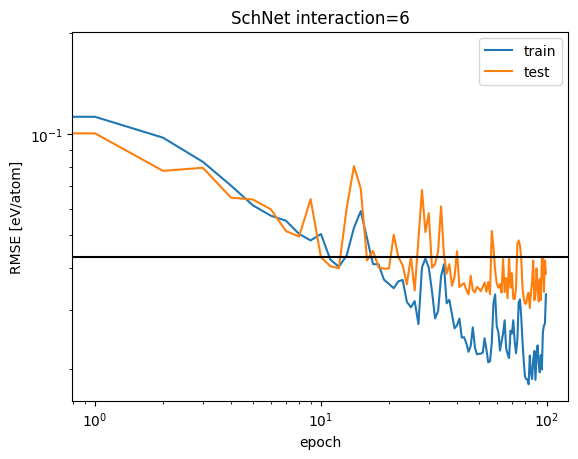

In [163]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("SchNet interaction=6")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

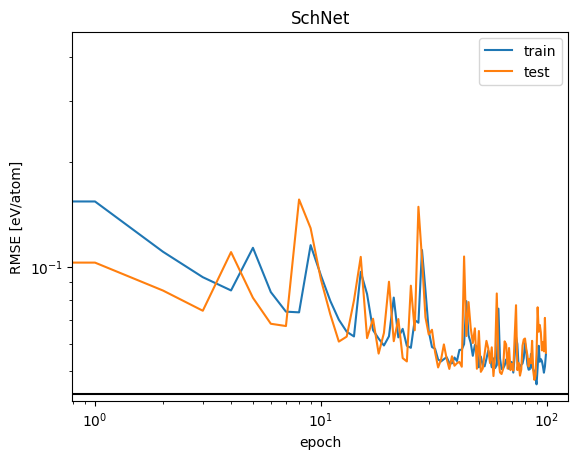

In [102]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("SchNet")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

## Training - Spliney

### Train one batch

In [203]:
model = Spliney(cutoff=CUTOFF, feature_size=128, layers_per_interaction=1, interaction=1,
                dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for batch in train_dataloader:
    y = batch.pop('scaled_dressed_energies_per_atom')
    train_loss = 0.
    for epoch_index in range(200):
        # Every data instance is an input + label pair
    
        # Zero your gradients for every batch!
        optimizer.zero_grad()
    
        # Make predictions for this batch
        y_pred = model.forward(**batch)
    
        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()
    
        # Adjust learning weights
        optimizer.step()
        train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    print("{0:0.5f}".format(train_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layer_linear.weight
_layer_linear.bias
_center_layers.0.0.weight
_center_layers.0.0.bias
_center_layer_linear.weight
_center_layer_linear.bias
_self_interaction_layers.0.0.0.weight
_self_interaction_layers.0.0.0.bias
_neighbor_interaction_layers.0.0.0.weight
_neighbor_interaction_layers.0.0.0.bias
_center_interaction_layers.0.0.0.weight
_center_interaction_layers.0.0.0.bias
_output_layer.weight
_output_layer.bias
_self_interaction_linear_layers.0.weight
_self_interaction_linear_layers.0.bias
_neighbor_interaction_linear_layers.0.weight
_neighbor_interaction_linear_layers.0.bias
_center_interaction_linear_layers.0.weight
_center_interaction_linear_layers.0.bias
0.01198
0.00969
0.01195
0.00599


KeyboardInterrupt: 

### Train whole dataset

In [103]:
model = Spliney(cutoff=CUTOFF, feature_size=128, layers_per_interaction=1, interaction=1,# neighbor_interaction=1,
                dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


TypeError: Spliney.__init__() got an unexpected keyword argument 'interaction'

In [104]:
model = Spliney(cutoff=CUTOFF, feature_size=128, layers_per_interaction=1,self_interaction=1,
                dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_self_interaction_layers.0.0.0.weight
_self_interaction_layers.0.0.0.bias
_output_layer.weight
_output_layer.bias
_self_interaction_linear_layers.0.weight
_self_interaction_linear_layers.0.bias
0.19798 0.17539
0.16457 0.13204
0.13413 0.10960
0.12113 0.09924
0.11357 0.09722
0.10941 0.09420
0.10484 0.09301
0.10202 0.08992
0.09722 0.08868
0.09315 0.09451
0.08958 0.08124
0.08206 0.07761
0.07699 0.07494
0.07294 0.07125
0.06875 0.06906
0.06519 0.07119
0.06553 0.06328
0.05984 0.06189
0.06325 0.06002
0.05713 0.05899
0.05547 0.05787
0.05710 0.05987
0.05573 0.06354
0.05497 0.06325
0.05501 0.05795
0.05216 0.05494
0.05107 0.05379
0.04995 0.05690
0.05174 0.05422
0.05187 0.05350
0.04927 0.05941
0.05224 0.05298
0.04797 0.05267
0.04835 0.06083
0.05546 0.05920
0.05000 0.05174
0.04781 0.05893
0.04816 0.05460
0.04781 0.06167
0.04953 0.05603
0.04901 0.05988
0.05187 0.05655
0.04815 0.05543
0.04794 0.05205
0.04696 0.05151
0.04636 0.05130
0.04

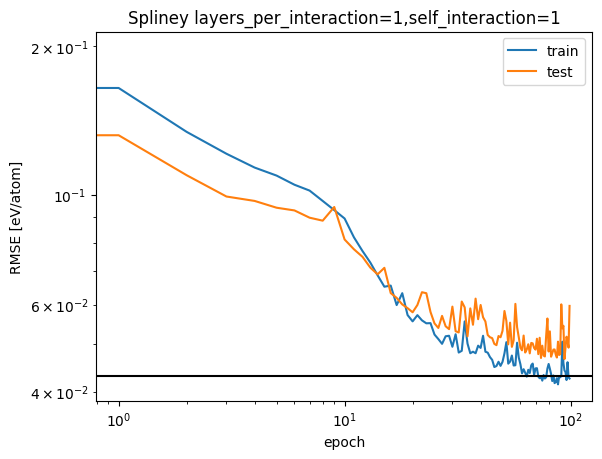

In [105]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("Spliney layers_per_interaction=1,self_interaction=1")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

In [180]:
#model = SplineyAggregate(cutoff=CUTOFF, feature_size=128,
#                layers_per_interaction=1,self_interaction=1, neighbor_interaction=1,
#                dtype=DTYPE, device=DEVICE)
model = Spliney(cutoff=CUTOFF, layers_per_interaction=3, self_interaction=3, dtype=DTYPE, device=DEVICE)
#model.to(dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

n_epoch = 200
train_losses = []
test_losses = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layers.1.0.weight
_layers.1.0.bias
_layers.2.0.weight
_layers.2.0.bias
_self_interaction_layers.0.0.0.weight
_self_interaction_layers.0.0.0.bias
_self_interaction_layers.0.1.0.weight
_self_interaction_layers.0.1.0.bias
_self_interaction_layers.0.2.0.weight
_self_interaction_layers.0.2.0.bias
_self_interaction_layers.1.0.0.weight
_self_interaction_layers.1.0.0.bias
_self_interaction_layers.1.1.0.weight
_self_interaction_layers.1.1.0.bias
_self_interaction_layers.1.2.0.weight
_self_interaction_layers.1.2.0.bias
_self_interaction_layers.2.0.0.weight
_self_interaction_layers.2.0.0.bias
_self_interaction_layers.2.1.0.weight
_self_interaction_layers.2.1.0.bias
_self_interaction_layers.2.2.0.weight
_self_interaction_layers.2.2.0.bias
_output_layer.weight
_output_layer.bias
_self_interaction_linear_layers.0.weight
_self_interaction_linear_layers.0.bias
_self_interaction_linear_layers.1.weight
_self_interaction_linear_layers.1.b

KeyboardInterrupt: 

In [181]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


0.08521 0.06428
0.05208 0.05225
0.04369 0.04837
0.04051 0.04466
0.03943 0.04423
0.03981 0.04923
0.04279 0.04900
0.03989 0.04425
0.03920 0.04680
0.04072 0.04513
0.04158 0.04708
0.04041 0.05060
0.04200 0.05873
0.04369 0.04382
0.04148 0.04770
0.04128 0.04801
0.04377 0.06374
0.04985 0.04891
0.04521 0.04718
0.04264 0.05081
0.04227 0.04926
0.04345 0.04389
0.03990 0.06174
0.04394 0.05034
0.04213 0.04392
0.04181 0.05027
0.04144 0.04697
0.04152 0.04642
0.03979 0.05135
0.04099 0.04768
0.04105 0.05988
0.04575 0.04535
0.04001 0.04498
0.03915 0.04456
0.03870 0.04342
0.04021 0.05578
0.04253 0.04444
0.03887 0.04503
0.04361 0.05329
0.04155 0.04497
0.04150 0.04749
0.04378 0.05110
0.04346 0.04603
0.04143 0.04716
0.03930 0.04898


KeyboardInterrupt: 

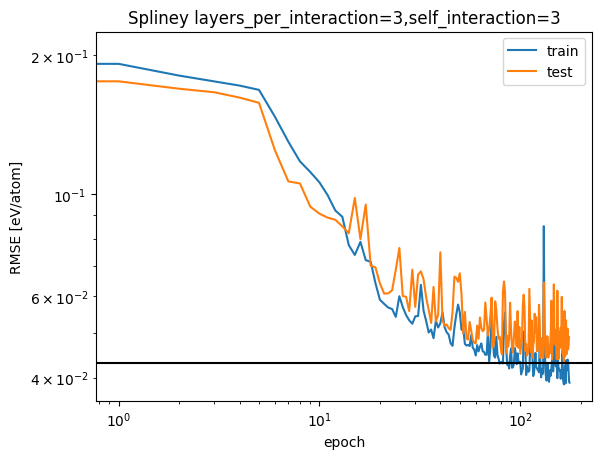

In [182]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("Spliney layers_per_interaction=3,self_interaction=3")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

In [112]:
model = Spliney(cutoff=CUTOFF, feature_size=128,
                layers_per_interaction=1,self_interaction=1, neighbor_interaction=1,
                dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epoch = 200
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_self_interaction_layers.0.0.0.weight
_self_interaction_layers.0.0.0.bias
_neighbor_interaction_layers.0.0.0.weight
_neighbor_interaction_layers.0.0.0.bias
_output_layer.weight
_output_layer.bias
_self_interaction_linear_layers.0.weight
_self_interaction_linear_layers.0.bias
_neighbor_interaction_linear_layers.0.weight
_neighbor_interaction_linear_layers.0.bias
0.20603 0.18251
0.18918 0.16024
0.16471 0.14038
0.14064 0.11394
0.12441 0.10357
0.11491 0.09613
0.10742 0.09092
0.10001 0.08677
0.09154 0.08247
0.08531 0.09025
0.08251 0.08377
0.07661 0.08176
0.07315 0.07432
0.06885 0.06855
0.06650 0.06821
0.06451 0.06568
0.06220 0.06317
0.06217 0.06245
0.05962 0.06049
0.05873 0.06080
0.05969 0.07148
0.05961 0.05956
0.05606 0.06017
0.05470 0.05644
0.05412 0.05626
0.05320 0.05547
0.05272 0.05500
0.05315 0.05418
0.05322 0.05505
0.05252 0.05466
0.05050 0.05298
0.04907 0.05235
0.04933 0.05381
0.04957 0.05512
0.05003 0.05035
0.04748 0.

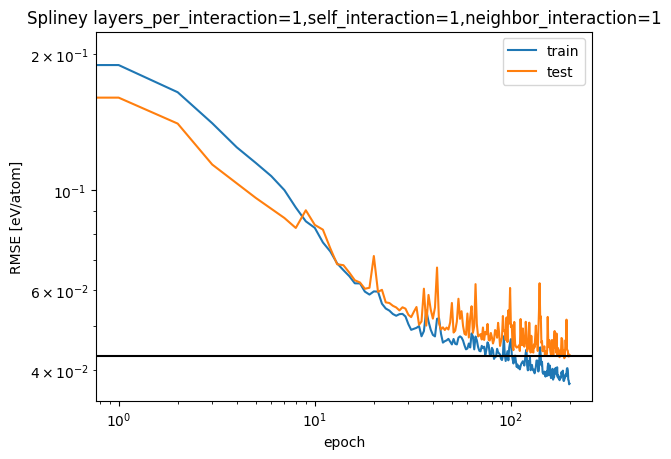

In [113]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("Spliney layers_per_interaction=1,self_interaction=1,neighbor_interaction=1")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

In [183]:
model = Spliney(cutoff=CUTOFF, feature_size=128,
                layers_per_interaction=3, self_interaction=1, neighbor_interaction=1,
                dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epoch = 200
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layers.1.0.weight
_layers.1.0.bias
_layers.2.0.weight
_layers.2.0.bias
_self_interaction_layers.0.0.0.weight
_self_interaction_layers.0.0.0.bias
_self_interaction_layers.0.1.0.weight
_self_interaction_layers.0.1.0.bias
_self_interaction_layers.0.2.0.weight
_self_interaction_layers.0.2.0.bias
_neighbor_interaction_layers.0.0.0.weight
_neighbor_interaction_layers.0.0.0.bias
_neighbor_interaction_layers.0.1.0.weight
_neighbor_interaction_layers.0.1.0.bias
_neighbor_interaction_layers.0.2.0.weight
_neighbor_interaction_layers.0.2.0.bias
_output_layer.weight
_output_layer.bias
_self_interaction_linear_layers.0.weight
_self_interaction_linear_layers.0.bias
_neighbor_interaction_linear_layers.0.weight
_neighbor_interaction_linear_layers.0.bias
0.20581 0.17967
0.17648 0.14475
0.13979 0.11698
0.12272 0.10158
0.11346 0.10281
0.10200 0.09554
0.09333 0.08198
0.08273 0.08830
0.07778 0.08094
0.07118 0.07817
0.07160 0.06863
0.06339 0.

KeyboardInterrupt: 

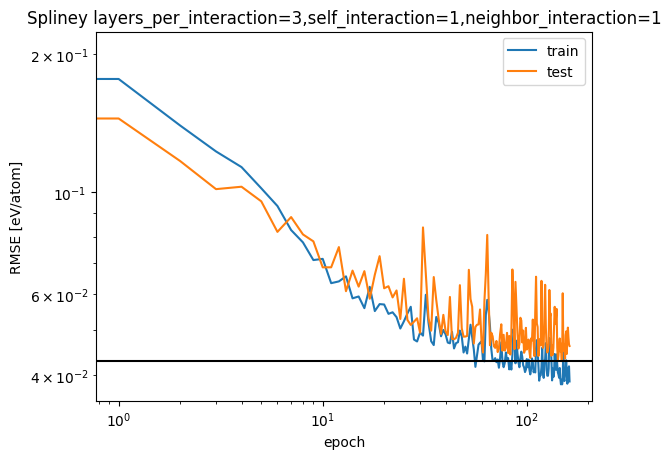

In [184]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("Spliney layers_per_interaction=3,self_interaction=1,neighbor_interaction=1")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

In [106]:
model = Spliney(cutoff=CUTOFF, feature_size=128, layers_per_interaction=2, self_interaction=0,
                dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layers.1.0.weight
_layers.1.0.bias
_output_layer.weight
_output_layer.bias
0.29832 0.21911
0.16594 0.11414
0.12787 0.10536
0.11598 0.10452
0.11039 0.09576
0.10615 0.09560
0.10409 0.09649
0.09908 0.09132
0.09674 0.08655
0.09309 0.09259
0.09258 0.09017
0.09109 0.08624
0.08868 0.08465
0.08153 0.08336
0.07965 0.07629
0.07775 0.07769
0.07443 0.07743
0.07428 0.08451
0.07746 0.08621
0.08024 0.10569
0.08449 0.07627
0.07505 0.06949
0.06809 0.07481
0.06971 0.07352
0.06776 0.08550
0.06944 0.11694
0.09260 0.14429
0.08865 0.12701
0.09706 0.13064
0.09597 0.06897
0.06761 0.06752
0.06490 0.06602
0.06409 0.06642
0.06382 0.07251
0.06439 0.06638
0.06374 0.07185
0.06257 0.06518
0.06433 0.06460
0.06409 0.06338
0.05990 0.06374
0.06080 0.06724
0.06051 0.06348
0.06214 0.06348
0.06156 0.06736
0.06147 0.06333
0.06121 0.08745
0.06972 0.06189
0.06207 0.06791
0.07195 0.10816
0.08660 0.08726
0.06291 0.07650
0.06261 0.06896
0.06894 0.06211
0.06209 0.

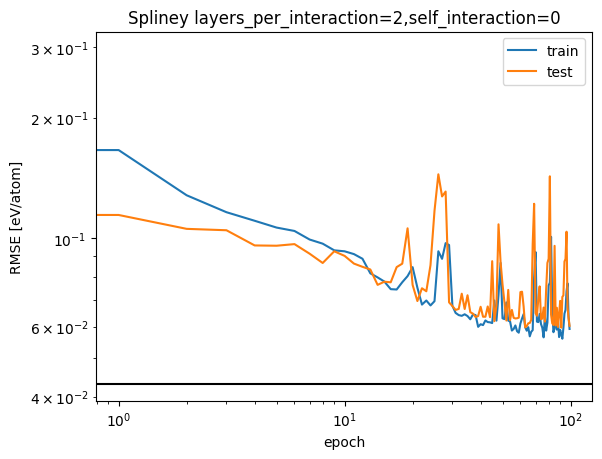

In [107]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("Spliney layers_per_interaction=2,self_interaction=0")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

### Allegro training

In [187]:
model = Allegro(cutoff=CUTOFF, feature_size=128, layers_per_interaction=2, interaction=3,
                dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layers.1.0.weight
_layers.1.0.bias
_layer_linear.weight
_layer_linear.bias
_center_layers.0.0.weight
_center_layers.0.0.bias
_center_layers.1.0.weight
_center_layers.1.0.bias
_center_layer_linear.weight
_center_layer_linear.bias
_self_interaction_layers.0.0.0.weight
_self_interaction_layers.0.0.0.bias
_self_interaction_layers.0.1.0.weight
_self_interaction_layers.0.1.0.bias
_self_interaction_layers.1.0.0.weight
_self_interaction_layers.1.0.0.bias
_self_interaction_layers.1.1.0.weight
_self_interaction_layers.1.1.0.bias
_self_interaction_layers.2.0.0.weight
_self_interaction_layers.2.0.0.bias
_self_interaction_layers.2.1.0.weight
_self_interaction_layers.2.1.0.bias
_neighbor_interaction_layers.0.0.0.weight
_neighbor_interaction_layers.0.0.0.bias
_neighbor_interaction_layers.0.1.0.weight
_neighbor_interaction_layers.0.1.0.bias
_neighbor_interaction_layers.1.0.0.weight
_neighbor_interaction_layers.1.0.0.bias
_neighbor_inte

KeyboardInterrupt: 

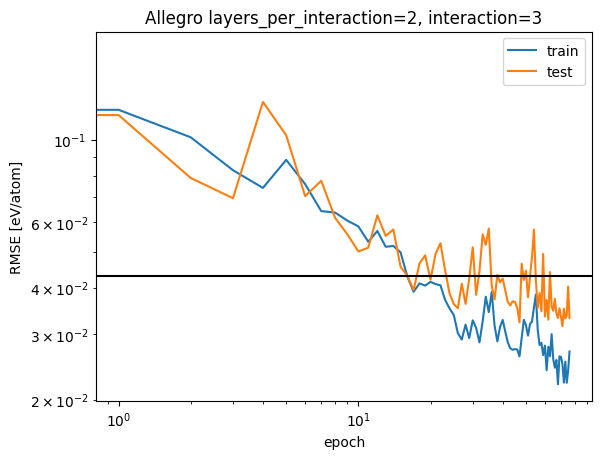

In [188]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("Allegro layers_per_interaction=2, interaction=3")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

In [194]:
for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


0.09712 0.18346
0.08765 0.18621
0.09335 0.21383
0.08484 0.20788
0.08707 0.19322
0.08231 0.18192
0.07974 0.19053
0.08681 0.17825
0.08229 0.19031
0.08298 0.18497
0.08140 0.17632
0.08173 0.18719
0.08430 0.20017
0.09085 0.19817
0.08591 0.18176
0.09898 0.19053
0.08619 0.18196
0.07902 0.18180
0.08668 0.18882
0.07936 0.17859
0.09240 0.19041
0.09969 0.18686
0.09597 0.18408
0.08305 0.17898
0.08345 0.18095
0.08317 0.18267
0.08196 0.17951
0.07853 0.17778
0.07437 0.18305
0.07862 0.18589
0.07817 0.18643
0.07779 0.19269
0.07928 0.17355
0.08236 0.18251
0.08478 0.17868
0.10269 0.21488
0.11627 0.18267
0.09037 0.16845
0.08620 0.17143
0.08675 0.18703
0.09014 0.17169
0.08241 0.18021
0.07784 0.17470
0.08211 0.18566
0.08322 0.17900
0.08385 0.19756
0.09816 0.18644
0.08243 0.17690
0.07963 0.17365
0.08253 0.18545
0.08615 0.18932
0.09535 0.18600
0.07875 0.18889
0.08235 0.17457
0.08091 0.17591
0.08143 0.18809
0.09242 0.18652
0.09087 0.17826
0.08284 0.17877
0.08273 0.17950
0.08080 0.19859
0.09272 0.17248
0.13784 

In [634]:
per_struc_loss = []
nb_atoms = []
with torch.no_grad():
    for batch in train_dataloader:
        # Gather data and report
        y = batch.pop('scaled_dressed_energies_per_atom')
        y_pred = model.forward(**batch)
        per_struc_loss.extend(((y_pred - y)**2).detach().cpu().numpy().tolist())
        nb_atoms.extend((batch['structure_offsets'][1:] - batch['structure_offsets'][:-1]).detach().cpu().numpy().tolist())
        nb_atoms.append(len(batch['positions']) - batch['structure_offsets'][-1].item())
        if any((y_pred - y)**2 > 1.0):
            idx = torch.argmax((y_pred - y)**2)
            print((torch.max((y_pred - y)**2)))
            print(batch['positions'][batch['structure_offsets'][idx]:batch['structure_offsets'][idx+1]])

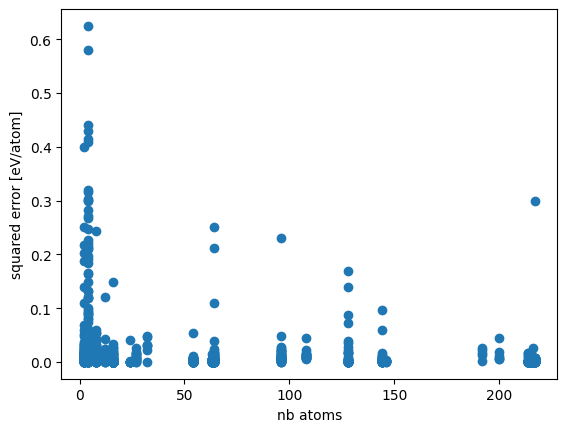

In [635]:
plt.scatter(nb_atoms, per_struc_loss)
plt.xlabel('nb atoms')
plt.ylabel('squared error [eV/atom]')
plt.show()
plt.close()

In [636]:
per_struc_loss = []
nb_atoms = []
with torch.no_grad():
    for batch in test_dataloader:
        # Gather data and report
        y = batch.pop('scaled_dressed_energies_per_atom')
        y_pred = model.forward(**batch)
        per_struc_loss.extend(((y_pred - y)**2).detach().cpu().numpy().tolist())
        nb_atoms.extend((batch['structure_offsets'][1:] - batch['structure_offsets'][:-1]).detach().cpu().numpy().tolist())
        nb_atoms.append(len(batch['positions']) - batch['structure_offsets'][-1].item())

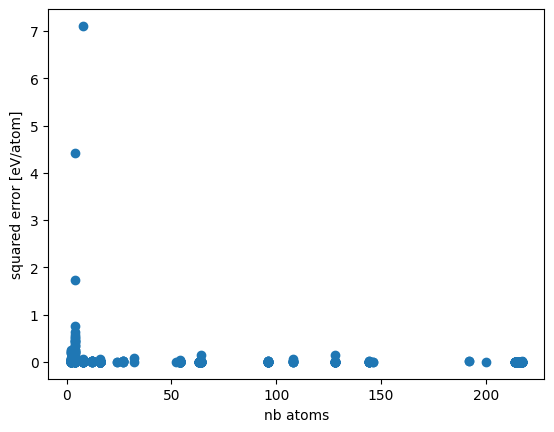

In [637]:
plt.scatter(nb_atoms, per_struc_loss)
plt.xlabel('nb atoms')
plt.ylabel('squared error [eV/atom]')
plt.show()
plt.close()

In [533]:
model = Spliney(cutoff=CUTOFF, feature_size=128, layers_per_interaction=3, self_interaction=0, neighbor_interaction=0,
                dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layers.1.0.weight
_layers.1.0.bias
_layers.2.0.weight
_layers.2.0.bias
_output_layer.weight
_output_layer.bias
1.98509 1.21100
0.84699 0.48362
0.53117 0.23477
0.25240 0.17849
0.19243 0.13254
0.15771 0.11039
0.14727 0.10212
0.14354 0.09845
0.14161 0.09983
0.14121 0.09884
0.14108 0.09584
0.13948 0.09445
0.13940 0.09552
0.13891 0.09229
0.13849 0.09209
0.13718 0.09124
0.13649 0.08956
0.13597 0.08881
0.13512 0.08853
0.13527 0.08833
0.13470 0.08602
0.13544 0.08498
0.13346 0.09151
0.13487 0.08727
0.13859 0.09651
0.13451 0.08359
0.13302 0.08377
0.13204 0.08283
0.13221 0.08442
0.13314 0.08062
0.13165 0.08397
0.13002 0.07926


KeyboardInterrupt: 

In [ ]:
for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


In [452]:
train_losses_lpr1_si0 = train_losses
test_losses_lpr1_si0 = test_losses

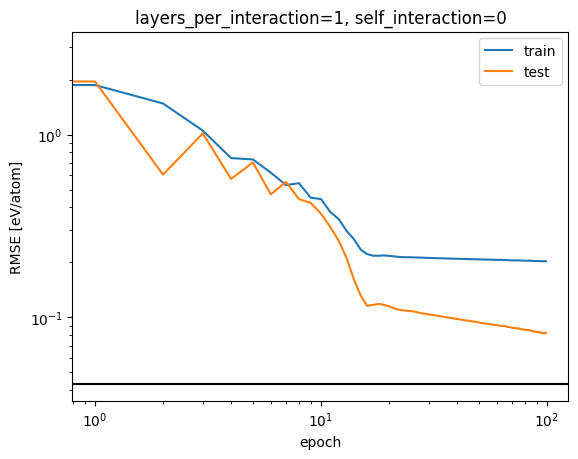

In [456]:
plt.loglog(train_losses_lpr1_si0, label='train')
plt.loglog(test_losses_lpr1_si0, label='test')
plt.title("layers_per_interaction=1, self_interaction=0")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.savefig("lr_lpr1_si0.png")
plt.show()
plt.close()

In [491]:
model = Spliney(cutoff=CUTOFF, feature_size=128, layers_per_interaction=0, self_interaction=0, neighbor_interaction=1, dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):   train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_output_layer.weight
_output_layer.bias
_neighbor_interaction_linear_layers.0.weight
_neighbor_interaction_linear_layers.0.bias
0.66471 0.64743
0.65428 0.63768
0.64474 0.62894
0.63807 0.62207
0.63406 0.61492
0.62588 0.60413
0.61490 0.58761
0.59662 0.56428
0.57522 0.53220
0.54574 0.49466
0.51143 0.45258
0.47639 0.41624
0.43833 0.37005
0.39914 0.33246
0.37222 0.29304
0.33611 0.25262
0.30366 0.22757
0.28166 0.19925
0.26839 0.16408
0.24801 0.16076
0.24152 0.13372
0.23300 0.13871
0.22636 0.11884
0.22200 0.12080
0.22000 0.11184
0.21678 0.10911
0.21494 0.10593
0.21351 0.10246
0.21213 0.10000
0.21144 0.09776
0.21032 0.09577
0.20943 0.09422
0.20902 0.09222
0.20799 0.09048
0.20734 0.08872
0.20674 0.08811
0.20606 0.09262
0.20726 0.08509
0.20603 0.08904
0.20608 0.08356
0.20569 0.08276
0.20438 0.08161
0.20360 0.07955
0.20307 0.07915
0.20306 0.07779
0.20311 0.08445
0.20303 0.07603
0.20306 0.07693
0.20195 0.07557
0.20109 0.07390
0.20074 0.07614
0.20078 0.07224
0.20010 0.

In [ ]:
model = Spliney(cutoff=CUTOFF, feature_size=128, layers_per_interaction=0, self_interaction=0, neighbor_interaction=1, dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


In [492]:
train_losses_lpr0_si0_ni1 = train_losses
test_losses_lpr0_si0_ni1 = test_losses

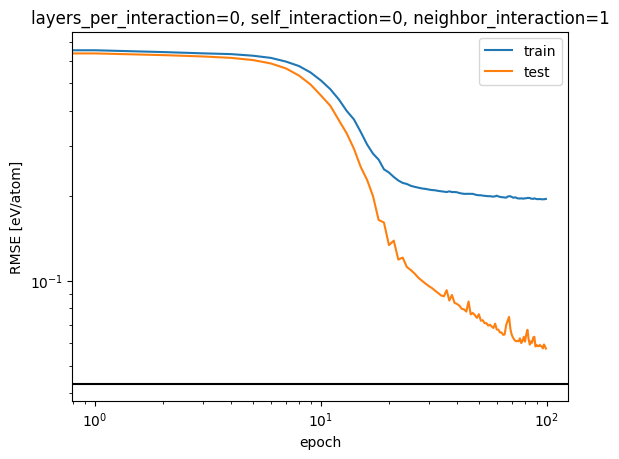

In [493]:
plt.loglog(train_losses_lpr0_si0_ni1, label='train')
plt.loglog(test_losses_lpr0_si0_ni1, label='test')
plt.title("layers_per_interaction=0, self_interaction=0, neighbor_interaction=1")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.savefig("lr_lpr0_si0_ni1.png")
plt.show()
plt.close()

In [500]:
model = Spliney(cutoff=CUTOFF, feature_size=128, layers_per_interaction=5, self_interaction=2, neighbor_interaction=2, dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layers.1.0.weight
_layers.1.0.bias
_layers.2.0.weight
_layers.2.0.bias
_self_interaction_layers.0.0.0.weight
_self_interaction_layers.0.0.0.bias
_self_interaction_layers.0.1.0.weight
_self_interaction_layers.0.1.0.bias
_self_interaction_layers.0.2.0.weight
_self_interaction_layers.0.2.0.bias
_self_interaction_layers.1.0.0.weight
_self_interaction_layers.1.0.0.bias
_self_interaction_layers.1.1.0.weight
_self_interaction_layers.1.1.0.bias
_self_interaction_layers.1.2.0.weight
_self_interaction_layers.1.2.0.bias
_neighbor_interaction_layers.0.0.0.weight
_neighbor_interaction_layers.0.0.0.bias
_neighbor_interaction_layers.0.1.0.weight
_neighbor_interaction_layers.0.1.0.bias
_neighbor_interaction_layers.0.2.0.weight
_neighbor_interaction_layers.0.2.0.bias
_neighbor_interaction_layers.1.0.0.weight
_neighbor_interaction_layers.1.0.0.bias
_neighbor_interaction_layers.1.1.0.weight
_neighbor_interaction_layers.1.1.0.bias
_neighbo

In [461]:
model = Spliney(cutoff=CUTOFF, feature_size=128, layers_per_interaction=0, self_interaction=1, dtype=DTYPE, device=DEVICE)

In [462]:
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

_layer.0.weight
_layer.0.bias
_output_layer.weight
_output_layer.bias
_self_interaction_linear_layers.0.weight
_self_interaction_linear_layers.0.bias


In [463]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [464]:
n_epoch = 100
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


0.66759 0.65383
0.65617 0.64242
0.64852 0.63054
0.63842 0.61834
0.62816 0.60710
0.61813 0.59231
0.60371 0.57295
0.58292 0.54713
0.55878 0.51143
0.52936 0.46921
0.48615 0.42885
0.44947 0.38748
0.41425 0.34859
0.37763 0.30889
0.34529 0.27624
0.31421 0.23201
0.28724 0.19918
0.26663 0.17106
0.25181 0.14852
0.24394 0.13514
0.23099 0.12963
0.22542 0.11630
0.22081 0.11061
0.21771 0.11323
0.21810 0.10627
0.21603 0.10200
0.21377 0.09863
0.21187 0.09578
0.21060 0.09359
0.21023 0.09625
0.21018 0.08899
0.20830 0.08759
0.20766 0.08580
0.20693 0.08339
0.20652 0.08382
0.20566 0.08126
0.20531 0.07946
0.20483 0.07889
0.20430 0.07921
0.20415 0.07748
0.20399 0.07886
0.20349 0.07654
0.20268 0.07360
0.20221 0.07342
0.20171 0.07166
0.20147 0.07310
0.20101 0.07351
0.20131 0.07402
0.20139 0.07560
0.20054 0.06967
0.20011 0.06676
0.20060 0.06663
0.20206 0.06601
0.20188 0.06498
0.19978 0.06472
0.19879 0.06469
0.19792 0.06344
0.19807 0.06270
0.19751 0.06237
0.19737 0.06382
0.19704 0.06138
0.19683 0.06088
0.19657 

In [467]:
train_losses_lpr0_si1 = train_losses
test_losses_lpr0_si1 = test_losses

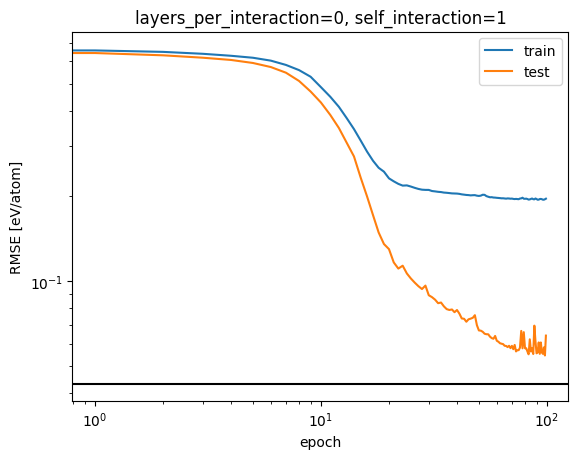

In [468]:
plt.loglog(train_losses_lpr0_si1, label='train')
plt.loglog(test_losses_lpr0_si1, label='test')
plt.title("layers_per_interaction=0, self_interaction=1")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.savefig("lr_lpr0_si1.png")
plt.show()
plt.close()

In [435]:
train_losses_lpr1_si1 = train_losses
test_losses_lpr1_si1 = test_losses


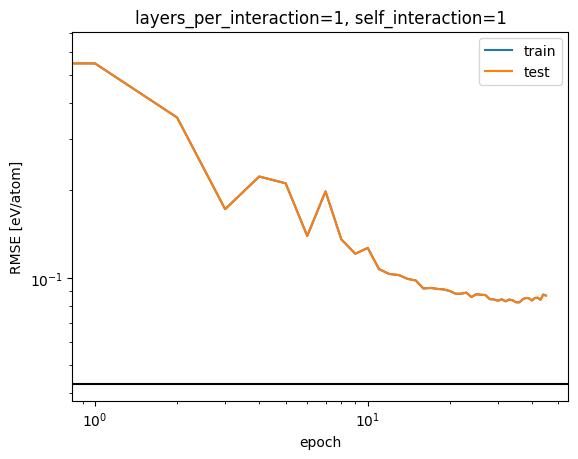

In [450]:
plt.loglog(train_losses_lpr1_si1, label='train')
plt.loglog(test_losses_lpr1_si1, label='test')
plt.title("layers_per_interaction=1, self_interaction=1")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.savefig("lr_lpr1_si1.png")
plt.show()
plt.close()

## Training - SchNet

In [193]:
from schnetpack as spk

#pairwise_distance = spk.atomistic.PairwiseDistances() # calculates pairwise distances between atoms
radial_basis = spk.nn.GaussianRBF(n_rbf=20, cutoff=cutoff)
schnet = spk.representation.SchNet(
    n_atom_basis=128,
    n_interactions=1,
    radial_basis=radial_basis,
    cutoff_fn=spk.nn.CosineCutoff(cutoff)
)


SyntaxError: invalid syntax (2528222753.py, line 1)

In [ ]:
schnet

## Training - RadialSpectrum

In [114]:
model = RadialSpectrum(cutoff=CUTOFF, feature_size=128, layers_per_interaction=5, self_interaction=0, neighbor_interaction=0,
                dtype=DTYPE, device=DEVICE)
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epoch = 200
train_losses = []
test_losses = []
train_losses_eV = []
test_losses_eV = []
nb_atoms = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        sum_loss = loss_fn(y_pred, y)
        #loss = torch.mean(sum_loss)
        sum_loss.backward()
        train_loss += sum_loss.item()

        # Adjust learning weights
        optimizer.step()

    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            sum_loss = loss_fn(y_pred, y)
            test_loss += sum_loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


_layer.0.weight
_layer.0.bias
_layers.0.0.weight
_layers.0.0.bias
_layers.1.0.weight
_layers.1.0.bias
_layers.2.0.weight
_layers.2.0.bias
_layers.3.0.weight
_layers.3.0.bias
_layers.4.0.weight
_layers.4.0.bias
_output_layer.weight
_output_layer.bias
0.24582 0.20150
0.18153 0.15061
0.11442 0.07764
0.07834 0.07449
0.06993 0.05823
0.05536 0.05285
0.05289 0.04989
0.04672 0.05150
0.04565 0.05644
0.05059 0.06090
0.04386 0.04905
0.04151 0.04791
0.04044 0.04369
0.03692 0.04909
0.04313 0.05122
0.03841 0.04231
0.03487 0.04193
0.03345 0.04022
0.03280 0.04199
0.03157 0.03796
0.03036 0.05746
0.03676 0.03913
0.03220 0.04637
0.03274 0.04256
0.03355 0.04567
0.03679 0.04801
0.03444 0.03818
0.03051 0.03565
0.02901 0.03544
0.02544 0.03656
0.02529 0.03702
0.02585 0.05134
0.03385 0.04160
0.02669 0.03841
0.02707 0.03673
0.02764 0.04257
0.02892 0.03783
0.03268 0.04197
0.03099 0.03503
0.02848 0.03660
0.02463 0.03212
0.02380 0.04345
0.02661 0.03552
0.02372 0.03272
0.02298 0.03584
0.02612 0.04189
0.02672 0.0371

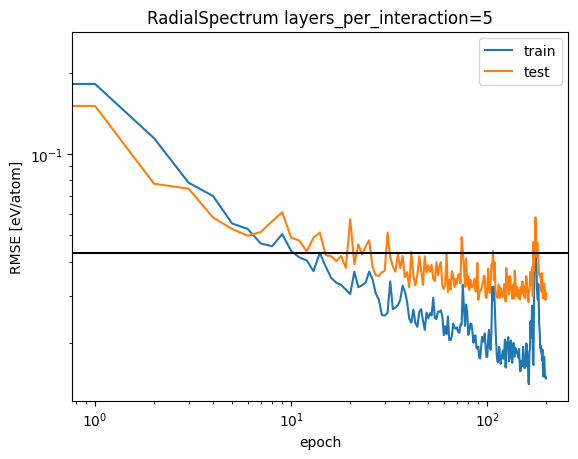

In [115]:
plt.loglog(train_losses, label='train')
plt.loglog(test_losses, label='test')
plt.title("RadialSpectrum layers_per_interaction=5")
plt.ylabel("RMSE [eV/atom]")
plt.xlabel("epoch")
plt.axhline(0.043, color='black')
plt.legend()
plt.show()
plt.close()

In [127]:
ys = []
with torch.no_grad():
    for batch in train_dataloader:
        # Gather data and report
        ys.extend(batch.pop('scaled_dressed_energies_per_atom').cpu().numpy().tolist())

In [129]:
print(train_losses[-1].item()/np.std(ys))

0.0709988529611064


In [125]:
loss_eV = []
with torch.no_grad():
    for batch in train_dataloader:
        # Gather data and report
        nb_atoms = torch.zeros(len(batch['structure_offsets']))
        y = batch.pop('scaled_dressed_energies_per_atom')
        y_pred = model.forward(**batch)
        nb_atoms[:-1] = batch['structure_offsets'][1:] - batch['structure_offsets'][:-1]
        nb_atoms[-1] = len(batch['positions']) - batch['structure_offsets'][-1].item()
        loss_eV.extend(torch.sqrt(((y_pred.cpu() - y.cpu())*nb_atoms)**2/BATCH_SIZE).detach().cpu().numpy().tolist())


In [126]:
print(np.sqrt(np.mean(loss_eV)))

0.30310307397776465


In [130]:
loss_eV = []
with torch.no_grad():
    for batch in test_dataloader:
        # Gather data and report
        nb_atoms = torch.zeros(len(batch['structure_offsets']))
        y = batch.pop('scaled_dressed_energies_per_atom')
        y_pred = model.forward(**batch)
        nb_atoms[:-1] = batch['structure_offsets'][1:] - batch['structure_offsets'][:-1]
        nb_atoms[-1] = len(batch['positions']) - batch['structure_offsets'][-1].item()
        loss_eV.extend(torch.sqrt(((y_pred.cpu() - y.cpu())*nb_atoms)**2/BATCH_SIZE).detach().cpu().numpy().tolist())
print(np.sqrt(np.mean(loss_eV)))

0.349809501152386


In [120]:
torch.zeros(BATCH_SIZE)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

In [406]:
model = RadialSpectrum(cutoff=CUTOFF, feature_size=128, layers_per_interaction=0, self_interaction=0, neighbor_interaction=0, dtype=DTYPE, device=DEVICE)

In [407]:
for name, parameter in model.named_parameters():
    print(name)
    if "bias" in name:
        torch.nn.init.zeros_(parameter)
    else:
        torch.nn.init.xavier_uniform_(parameter)

_layer.0.weight
_layer.0.bias
_output_layer.weight
_output_layer.bias


In [408]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [409]:
n_epoch = 50
train_losses = []
test_losses = []

for epoch_index in range(n_epoch):
    train_loss = 0.
    for batch in train_dataloader:
        # Every data instance is an input + label pair
        y = batch.pop('scaled_dressed_energies_per_atom')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        y_pred = model.forward(**batch)

        # Compute the loss and its gradients
        loss = loss_fn(y_pred, y)
        loss.backward()
        train_loss += loss.item()

        # Adjust learning weights
        optimizer.step()
    train_loss = np.sqrt(train_loss / len(train_dataloader.dataset)) # loss per batch
    train_losses.append(train_loss)

    test_loss = 0.
    with torch.no_grad():
        for batch in test_dataloader:
            # Gather data and report
            y = batch.pop('scaled_dressed_energies_per_atom')
            y_pred = model.forward(**batch)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
    test_loss = np.sqrt(test_loss / len(test_dataloader.dataset)) # loss per batch
    test_losses.append(test_loss)
    
    print("{0:0.5f}".format(train_loss), "{0:0.5f}".format(test_loss))


0.76099 0.61322
0.60491 0.55382
0.58083 0.53394
0.54297 0.49386
0.50497 0.46114
0.47654 0.42877
0.44832 0.39608
0.42712 0.37171
0.40510 0.34911
0.38588 0.32604
0.36587 0.30730
0.34638 0.28916
0.33194 0.27056
0.31691 0.25265
0.30185 0.23677
0.29012 0.22212
0.27799 0.20785
0.26754 0.19451
0.25754 0.18260
0.24872 0.17179
0.24111 0.16176
0.23302 0.15268
0.22728 0.14385
0.22132 0.13673
0.21704 0.12962
0.21238 0.12398
0.20880 0.11884
0.20520 0.11469
0.20273 0.11066
0.20043 0.10729
0.19870 0.10414
0.19678 0.10153
0.19509 0.09956
0.19388 0.09775
0.19279 0.09603
0.19176 0.09467
0.19100 0.09321
0.19026 0.09233
0.18959 0.09145
0.18889 0.09062
0.18824 0.08985
0.18784 0.08914
0.18737 0.08840
0.18693 0.08774
0.18660 0.08705
0.18624 0.08644
0.18605 0.08585
0.18562 0.08545
0.18515 0.08500
0.18496 0.08443


In [244]:
debug_dataset = InMemoryDataset(frames[::10],
                          [TransformerNeighborList(cutoff=CUTOFF, dtype=DTYPE),
                           TransformerProperty("scaled_dressed_energies_per_atom",
                                               get_dressed_energy_per_atom, dtype=torch.float64)])

In [245]:
debug_dataloader = torch.utils.data.DataLoader(debug_dataset, batch_size=100, collate_fn=collate_nl, shuffle=False)

In [300]:
big_dataloader = torch.utils.data.DataLoader(big_dataset, batch_size=100, collate_fn=collate_nl, shuffle=False)

In [316]:
model_rs = RadialSpectrum(cutoff=CUTOFF, feature_size=128, layers_per_interaction=0, self_interaction=0, neighbor_interaction=0,
                          dtype=torch.float32)

In [317]:
rs_repr = []
ys = []
for batch in big_dataloader:
    ys.append(batch.pop('scaled_dressed_energies_per_atom'))

    # Make predictions for this batch
    x = model_rs.forward_repr(**batch)
    rs_repr.append(x)
    

In [302]:
len(rs_repr)

9

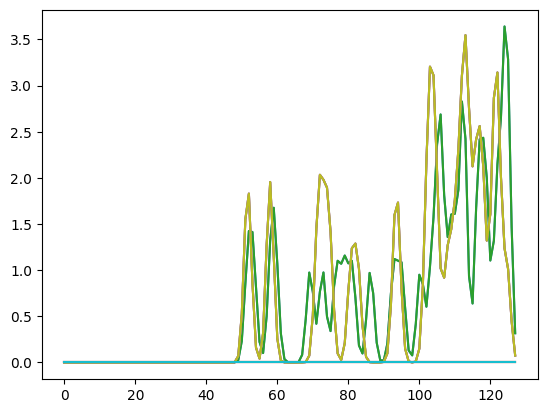

In [292]:
torch.manual_seed(0)
idx = torch.randint(len(rs_repr), size=(10,))
#idx = [10]
for i in idx:
    plt.plot(rs_repr[i//100][i%100].detach().numpy())
plt.show()
plt.close()

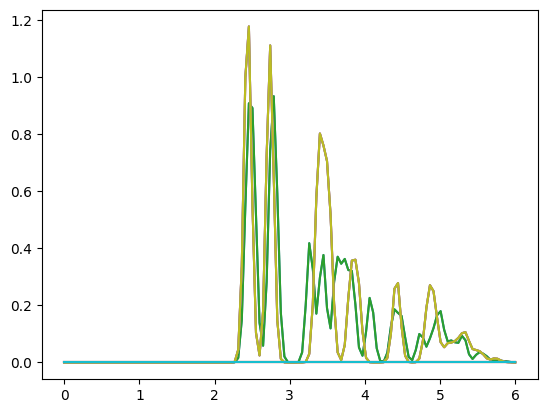

In [289]:
for i in idx:
    plt.plot(np.linspace(0, CUTOFF, 128), rs_repr[i//100][i%100].detach().numpy())
plt.show()
plt.close()

In [318]:
X = torch.cat(rs_repr)

In [319]:
y = torch.cat(ys)

In [320]:
print(X.shape)
print(y.shape)

torch.Size([825, 128])
torch.Size([825])


In [321]:
print(X.dtype)
print(y.dtype)

torch.float32
torch.float32


In [322]:
w = torch.linalg.lstsq(X, y).solution

In [325]:
Xnp = X.detach().numpy()
ynp = y.detach().numpy()

In [343]:
from sklearn.linear_model import RidgeCV, Ridge

In [350]:
ridge = Ridge(alpha=1e-3).fit(Xnp, ynp)
def loss_fn_numpy(pred, true):
    return np.sqrt(np.mean((pred - true)**2))

loss_fn_numpy(ridge.predict(Xnp), ynp)

0.14705949

In [344]:
for batch in train_dataloader:
    ys.append(batch.pop('scaled_dressed_energies_per_atom'))

    # Make predictions for this batch
    x = model_rs.forward_repr(**batch)
    rs_repr.append(x)
X_train = torch.cat(rs_repr).detach().numpy()
y_train = torch.cat(ys).detach().numpy()

In [345]:
for batch in test_dataloader:
    ys.append(batch.pop('scaled_dressed_energies_per_atom'))

    # Make predictions for this batch
    x = model_rs.forward_repr(**batch)
    rs_repr.append(x)
X_test = torch.cat(rs_repr).detach().numpy()
y_test = torch.cat(ys).detach().numpy()


In [351]:
loss_fn_numpy(ridge.predict(X_test), y_test)

0.18802598

In [323]:
loss_fn(X@w, y)

tensor(0.4225)

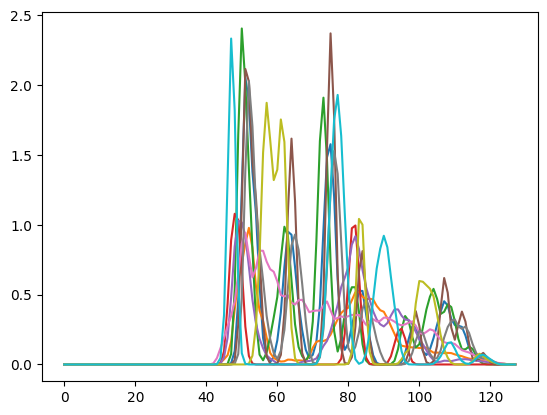

In [324]:
for i in torch.randint(len(X), size=(10,)):
    plt.plot(X[i].detach().numpy())
plt.show()
plt.close()

In [246]:
rs_embedding = []
ys = []
for batch in big_dataloader:
    ys.append(batch.pop('scaled_dressed_energies_per_atom'))

    # Make predictions for this batch
    x = model_rs.forward_embedding(**batch)
    rs_embedding.append(x)
X = torch.cat(rs_embedding)

In [ ]:
for i in torch.randint(len(X), size=(10,)):
    plt.plot(X[i].detach().numpy())
plt.show()
plt.close()

In [ ]:
plt.plot(linear_embedding(torch.linspace(0,5,10)).detach().numpy().T) 
plt.show()
plt.close()

In [ ]:
plt.plot(linear_embedding(torch.linspace(0,5,10)).detach().numpy().sum(0)) 
plt.show()
plt.close()

In [ ]:
linear_embedding(torch.linspace(0,5,100)).shape